<a href="https://colab.research.google.com/github/HenryVRosas/hojas_chocloCNN/blob/main/Hojas_choclo_trasnferlearningooglenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transfer Learning
- Wifi y LTE
- pytorch


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Autenticación y creación del cliente de PyDrive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# ID del archivo compartido en Google Drive
file_id = '17iE3GKYb0hWjWIYNc1coB99oB3wHaYPq'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('archivo.zip')  # Nombre con el que se guardará el archivo en Colab

# Ruta de destino para descomprimir en Google Drive
extract_path = '/content/drive/My Drive/extracted'  # Especifica una ruta en tu Google Drive

# Crear el directorio de destino si no existe
os.makedirs(extract_path, exist_ok=True)

# Descomprimir el archivo .zip
with zipfile.ZipFile('archivo.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Descompresión completa")

Descompresión completa


In [3]:
#Listo las carpetas que contiene el dataset
!ls '/content/drive/My Drive/extracted/dataset_choclo'

test  train  val


In [4]:
#Verifico la capacidad de GPU
!nvidia-smi

Wed Jul  3 03:11:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
# Añadir esto al inicio de tu script
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [6]:
#Librerias a importar
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import time
import copy

Carga de las imágenes para entrenamiento

La normalizacion de las imágenes utiliza datos de Imagenet [0.485, 0.456, 0.406],                       [0.229, 0.224, 0.225]

Para val se añadio data augmentation, al tener pocas imagenes.

In [7]:
# Cargar las imagenes - datset

train_dataset = torchvision.datasets.ImageFolder('/content/drive/My Drive/extracted/dataset_choclo/train',
                                                transform=transforms.Compose([
                                                    transforms.RandomResizedCrop(224),
                                                    transforms. ToTensor(),
                                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                                         [0.229, 0.224, 0.225])  # De imagenet

                                                ]))
val_dataset = torchvision.datasets.ImageFolder('/content/drive/My Drive/extracted/dataset_choclo/val',
                                                  transform=transforms.Compose([
                                                  transforms.RandomRotation(10),
                                                  transforms.RandomHorizontalFlip(),
                                                  transforms.Resize(256),
                                                  transforms.CenterCrop(224),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                                         [0.229, 0.224, 0.225])

                                                ]))

test_dataset = torchvision.datasets.ImageFolder('/content/drive/My Drive/extracted/dataset_choclo/test',
                                              transform=transforms.Compose([
                                                    transforms.Resize(256),
                                                    transforms.CenterCrop(224),
                                                    transforms. ToTensor(),
                                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                                         [0.229, 0.224, 0.225])

                                                ]))


print(train_dataset)
print(val_dataset)
print(test_dataset)

Dataset ImageFolder
    Number of datapoints: 2936
    Root location: /content/drive/My Drive/extracted/dataset_choclo/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset ImageFolder
    Number of datapoints: 626
    Root location: /content/drive/My Drive/extracted/dataset_choclo/val
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset ImageFolder
    Numbe

Se prepara los "loader" para train, val y test. Se utilizara un batch_size = 32


In [8]:
batch_size = 32
learning_rate = 0.001
num_epocas = 15
step_log = 100

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size = batch_size,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                         batch_size = batch_size,
                                         shuffle=False)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size = batch_size,
                                         shuffle=True)

class_names = train_dataset.classes

Se visualiza 4 imágenes de un batch tomados de train_loader, se añade los datos de normalizacion para la correcta visualizacion de las imágenes

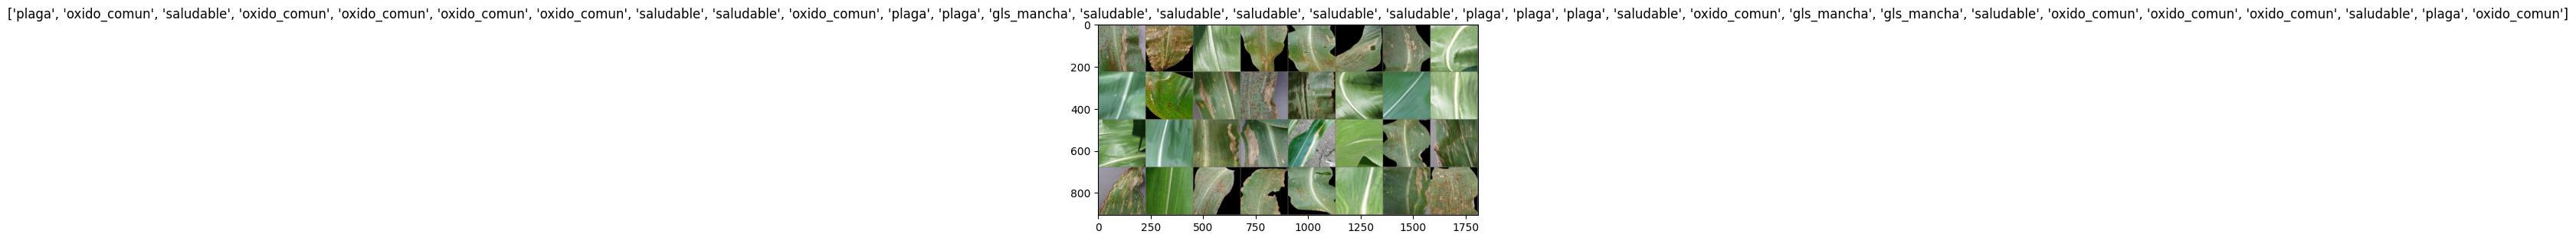

In [9]:
def imshow(inp, title = None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)

  if title is not None:
    plt.title(title)
  plt.pause(0.001)

inputs, classes = next(iter(val_loader))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

GPU para el enternamiento, verifico que se utilize CUDA
0-> para el primer gpu
1-> para seleccionar el segundo GPU en caso se tuviera

In [10]:
torch.cuda.set_device(0)
device = ('cuda' if torch.cuda.is_available() else 'cpu')

print("Se entrenara con:", device)

Se entrenara con: cuda


Arquitectura de la red

Función de entrenamiento para train y val

Se añade comentarios tomados de la documentación y foros explicando el proceso y parámetros utilizados

In [11]:
#Modelo
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_acc_train = 0.0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 25)

        #Train model

        #Tells your model that you are training the model
        model.train()

        running_loss = 0.0
        running_corrects = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            #In PyTorch, we need to set the gradients to zero before starting to do backpropragation
            #because PyTorch accumulates the gradients on subsequent backward passes.
            optimizer.zero_grad()

            outputs = model(inputs)

            #Si utilizo softmax, puedo usar exp
            #We are doing it here just to make our predictions look like probabilities
            #which sometimes helps in debugging. You are free to remove torch.exp
            #call in the code if you want. torch.max returns a tuple containing the maximum value
            #and the index of the maximum value within the tensor. Since the index in our case
            #represents the classified category itself, we will only take that ignoring
            #the actual probability.
            #_, preds = torch.max(torch.exp(outputs), 1)

            #pytorch.max
            #Returns the maximum value of all elements in the input tensor.
            _, preds = torch.max(outputs, 1)

            #you should use labels, because u need to get loss by comparing ground truth
            #and predicting label, the predict is outputs, and the ground truth is labels
            loss = criterion(outputs, labels)

            #loss.backward() computes dloss/dx for every parameter x which has
            #requires_grad=True. These are accumulated into x.grad for every parameter x
            loss.backward()

            #optimizer.step updates the value of x using the gradient x.grad
            optimizer.step()



            #the loss returned is an average over all examples in a batch, given this,
            #you could simply divide the running loss by the number of batches,
            #however since the final batch is often not the same size with others,
            #your results would be inaccurate, hence, the solution is to reverse the average
            #by multiplying the loss in a batch by the total number of images in the batch,
            #this gives unaveraged sum of losses over all examples, when you divide the running loss
            #by the total number of images ,you get accurate loss metrics.
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        #During an epoch, we need to update the LR using the ‘.step()’ method of the scheduler object
        scheduler.step()

        epoch_loss_train = running_loss /len(train_dataset)
        epoch_acc_train = running_corrects.double() / len(train_dataset)

        train_losses.append(epoch_loss_train)
        train_accuracies.append(epoch_acc_train.item())

        print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_train, epoch_acc_train))
        if epoch_acc_train > best_acc_train:
              best_acc_train = epoch_acc_train


        #Validation
        model.eval()
        running_loss = 0.0
        running_corrects = 0.0

        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            #Context-manager that sets gradient calculation to on or off
            #Disabling gradient calculation is useful for inference, when you are sure that you will
            #not call Tensor.backward(). It will reduce memory consumption for computations that would
            #otherwise have requires_grad=True.
            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        epoch_loss_val = running_loss /len(val_dataset)
        epoch_acc_val = running_corrects.double() / len(val_dataset)

        val_losses.append(epoch_loss_val)
        val_accuracies.append(epoch_acc_val.item())

        print('Val Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_val, epoch_acc_val))

        if epoch_acc_val > best_acc:
              best_acc = epoch_acc_val
              best_model_wts = copy.deepcopy(model.state_dict())
              torch.save(best_model_wts, 'resnetxt.pth')

    time_elapsed = time.time() - since
    print("####################################################")
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed % 60))
    print('Best train accucary: {:.4f}'.format(best_acc_train))
    print('Best val accucary: {:.4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)

    time_elapsed = time.time() - since
    print("####################################################")
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best train accuracy: {:.4f}'.format(best_acc_train))
    print('Best val accuracy: {:.4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)

    # Plotting training and validation loss
    plt.figure(figsize=(10, 5))
    plt.title("Training and Validation Loss")
    plt.plot(train_losses, label="train")
    plt.plot(val_losses, label="val")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plotting training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.title("Training and Validation Accuracy")
    plt.plot(train_accuracies, label="train")
    plt.plot(val_accuracies, label="val")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    return model

Funcion test

In [12]:
def test_model(model):
    model.eval()
    running_loss = 0.0
    running_corrects = 0.0

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss /len(test_dataset)
    epoch_acc = running_corrects.double() / len(test_dataset)

    print('Test Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    return test_model

Visualizar el resultado, se utiliza imagenes en test

In [25]:
def visualize_model(model, num_images):
    was_training = model.training

    model.eval()
    images_so_far = 0

    #fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far +=1
                ax = plt.subplot(num_images, 1, images_so_far)

                ax.axis('off')
                ax.set_title('Predicted: {} (Clase: {})'.format(class_names[preds[j]], class_names[labels[j]]))

                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

        model.train(mode = was_training)


torch.hub.list(github, force_reload=False, skip_validation=False)###Entrenamiento 1

Función de pérdida: CrossEntropyLoss

Optimizador: stochastic gradient descent SGD

In [26]:
import torchvision.models as models
model_googlenet = models.googlenet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 163MB/s]


In [27]:
# Arquitectura del modelo
model_googlenet

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [28]:
# Ajustar la última capa del modelo para el número de clases en tu problema (4)
num_ftrs = model_googlenet.fc.in_features
model_googlenet.fc = nn.Linear(num_ftrs, 4)

In [29]:
# Mover el modelo a la GPU
model_googlenet = model_googlenet.to(device)

In [30]:
# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_googlenet.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


Pruebo el entrenamiento con los datos de test

Epoch 0/14
-------------------------
Train Loss: 0.8593 Acc: 0.6778
Val Loss: 0.4235 Acc: 0.8450
Epoch 1/14
-------------------------
Train Loss: 0.4007 Acc: 0.8580
Val Loss: 0.2576 Acc: 0.9201
Epoch 2/14
-------------------------
Train Loss: 0.3030 Acc: 0.8907
Val Loss: 0.2115 Acc: 0.9185
Epoch 3/14
-------------------------
Train Loss: 0.2591 Acc: 0.8985
Val Loss: 0.1823 Acc: 0.9297
Epoch 4/14
-------------------------
Train Loss: 0.2275 Acc: 0.9213
Val Loss: 0.1586 Acc: 0.9377
Epoch 5/14
-------------------------
Train Loss: 0.2243 Acc: 0.9087
Val Loss: 0.1576 Acc: 0.9441
Epoch 6/14
-------------------------
Train Loss: 0.2074 Acc: 0.9271
Val Loss: 0.1499 Acc: 0.9457
Epoch 7/14
-------------------------
Train Loss: 0.2025 Acc: 0.9257
Val Loss: 0.1475 Acc: 0.9505
Epoch 8/14
-------------------------
Train Loss: 0.1976 Acc: 0.9298
Val Loss: 0.1439 Acc: 0.9473
Epoch 9/14
-------------------------
Train Loss: 0.1912 Acc: 0.9275
Val Loss: 0.1540 Acc: 0.9425
Epoch 10/14
------------------

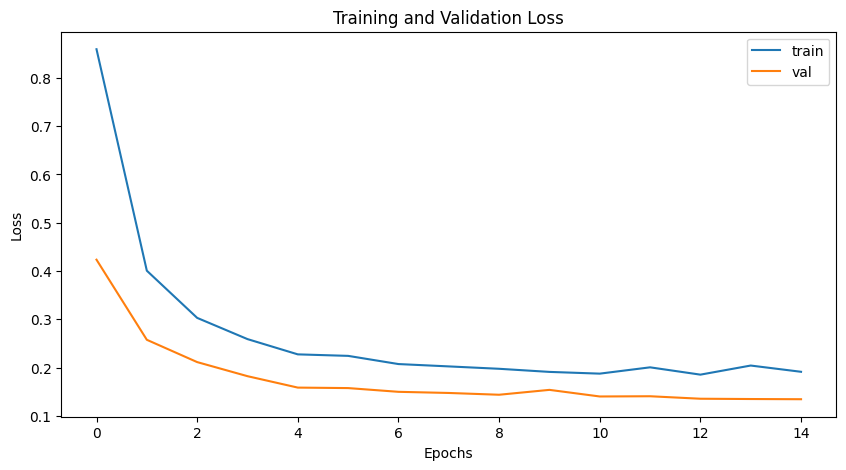

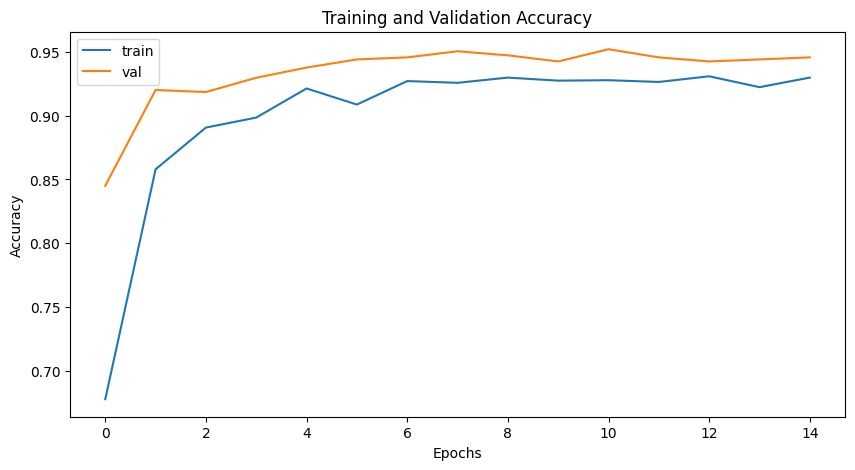

In [31]:
model_googlenet = train_model(model_googlenet, criterion, optimizer, scheduler, num_epochs=num_epocas)


Visualización de resultados en test

In [32]:
model_googlenet_test = test_model(model_googlenet)

Test Loss: 0.1279 Acc: 0.9649


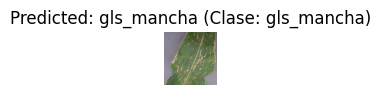

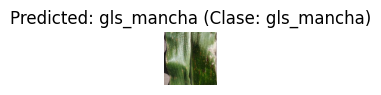

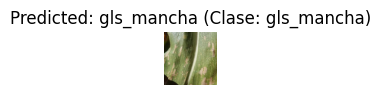

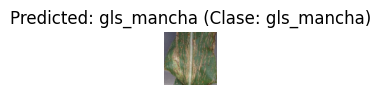

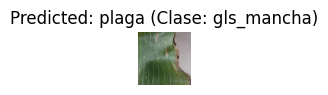

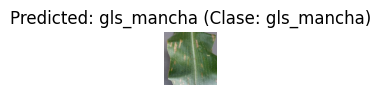

In [33]:
visualize_model(model=model_googlenet, num_images=6)